In [7]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE,SVMSMOTE,KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
full_lc_pd = pd.read_csv("../dataset/light_curve_dataframe/eclipsing_binary/lc_eclipsing_binary.csv")
full_lc_pd

,source_id,raj2000,dej2000,l,b,mean_vmag,amplitude,period,variable_type,class_probability,...,h_k,depth_ratio,slope_diff_ratio,similarity,phase_eta,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum
0,78719,280.33355,44.91092,73.88900,20.46931,14.25,0.43,0.369614,EW,1.000,...,0.114,0.000000,1.107516,0.987844,0.069590,-0.107168,0.105149,-0.044136,0.048258,0.272312
1,566495,104.05142,-9.43459,221.87734,-3.23794,12.40,0.21,1.992654,EW,0.351,...,0.310,0.012931,1.211936,0.966092,0.539229,-1.484450,1.349271,-0.698874,0.537312,0.197429
2,566495,104.05142,-9.43459,221.87734,-3.23794,12.40,0.21,1.992654,EW,0.351,...,0.310,0.003802,2.353940,0.975938,0.887772,-0.592608,0.904362,-0.251150,0.370921,0.216416
3,124535,352.58827,21.71119,99.03928,-37.36992,13.18,0.36,0.412779,EW,1.000,...,0.087,0.021739,1.109102,0.983095,0.046302,-0.298712,0.267680,-0.161734,0.096642,0.250773
4,124535,352.58827,21.71119,99.03928,-37.36992,13.18,0.36,0.412779,EW,1.000,...,0.087,0.002525,1.348041,0.982628,0.089193,-0.203587,0.226081,-0.098112,0.109488,0.230508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127334,AP47330754,251.26582,-75.64354,315.84186,-19.03429,13.67,0.13,0.468586,EW,0.998,...,0.045,0.042945,1.085785,0.956323,0.715128,-0.353347,0.371974,-0.169320,0.148949,0.211349
127335,459142,78.84403,-49.75804,256.40550,-35.59533,13.44,0.50,5.021012,EA,0.997,...,0.066,0.556114,6.169001,0.950807,0.844292,-11.960270,10.664640,-4.298160,3.294531,0.161760
127336,459142,78.84403,-49.75804,256.40550,-35.59533,13.44,0.50,5.021012,EA,0.997,...,0.066,0.284936,1.264316,0.939473,0.293483,-4.076498,3.908200,-1.559490,1.362397,0.165524
127337,99717,330.37822,21.41504,78.35259,-26.39519,14.16,0.17,0.402175,EW,0.872,...,0.054,0.010363,1.115968,0.971849,0.374355,-0.173481,0.144664,-0.080845,0.057095,0.234512


In [37]:
Mm_ratio = full_lc_pd["Mm_ratio"].values
variable_type = full_lc_pd["variable_type"].values
similarity = full_lc_pd["similarity"].values
period = full_lc_pd["period"].values

variable_type = LabelEncoder().fit_transform(variable_type)



Mm_ratio_idx = np.intersect1d(np.argwhere(
        np.percentile(Mm_ratio, 20) < Mm_ratio), np.argwhere(
        np.percentile(Mm_ratio, 80) > Mm_ratio))
similarity_idx = np.intersect1d(np.argwhere(
        np.percentile(similarity, 20) < similarity), np.argwhere(
        np.percentile(similarity, 80) > similarity))
period_idx = np.intersect1d(np.argwhere(
        np.percentile(period, 20) < period), np.argwhere(
        np.percentile(period, 80) > period))
print(Mm_ratio_idx)
idx1 = np.intersect1d(Mm_ratio_idx, similarity_idx)
idx = np.intersect1d(idx1, period_idx)
print(idx)
# Mm_ratio = (Mm_ratio-np.min(Mm_ratio))/(np.max(Mm_ratio)-np.min(Mm_ratio))
# similarity = (similarity-np.min(similarity))/(np.max(similarity)-np.min(similarity))
# period = (period-np.min(period))/(np.max(period)-np.min(period))

[     0      1      2 ... 127332 127333 127338]
[     7     11     17 ... 127329 127332 127333]


In [38]:
full_lc_pd = full_lc_pd.iloc[idx]
Mm_ratio = full_lc_pd["Mm_ratio"].values
variable_type = full_lc_pd["variable_type"].values
similarity = full_lc_pd["similarity"].values
period = full_lc_pd["period"].values

variable_type = LabelEncoder().fit_transform(variable_type)
Mm_ratio
# Mm_ratio = np.log10(Mm_ratio)
# similarity = np.log10(similarity)
# period = np.log10(period)

array([2.24489796, 1.93023256, 7.73684211, ..., 1.9625    , 2.25      ,
       1.75757576])

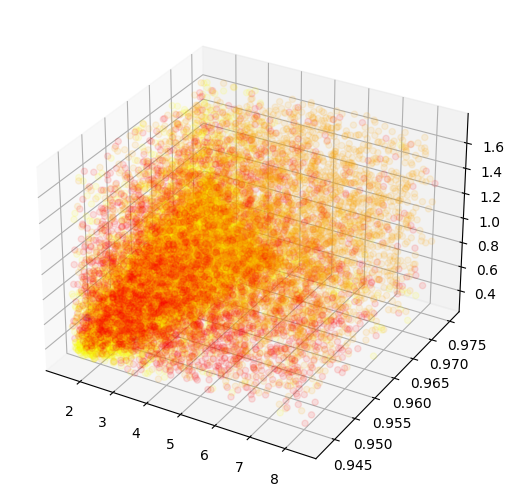

In [46]:
from mpl_toolkits.mplot3d import Axes3D

map_color = {0:'orange',1:'red',2:'b',3:'yellow'}
color = [map_color[i] for i in variable_type]


fig = plt.figure()
ax = Axes3D(fig)
fig.add_axes(ax)
ax.scatter(Mm_ratio, similarity, period, c=color,alpha=0.1)
plt.show()